In [1]:
import torch
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
#Loading model
import sys
import os
import torch
# Get the current script's directory
current_directory = os.getcwd()
print(current_directory)
library_directory = os.path.abspath(os.path.join(current_directory, 'torchVersion', 'BLIP'))
sys.path.append(library_directory)
from BLIP.utils.models.blip_vqa import blip_vqa

model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_vqa_capfilt_large.pth'
#model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_vqa.pth'

image_size = 640
model = blip_vqa(pretrained=model_url, image_size=image_size, vit='base')
model = model.to(device)


cuda
c:\Users\mr_pa\Documents\Uni\FoundationModels\Multiple-choice-VQA
reshape position embedding from 900 to 1600
load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_vqa_capfilt_large.pth


In [2]:
print(model.text_decoder)

BertLMHeadModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30524, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (dropout): Dropout(p=0.

In [2]:
import sys
sys.path.append('../')  # Adjust the path accordingly
from VQA_Dataset_BLIP import VQA_Dataset_preloaded_TorchVersion,VQA_Dataset_preloaded_alternativ

dataset_train = VQA_Dataset_preloaded_alternativ(device, image_size=image_size)#, folder_path="E:/")
dataset_val = VQA_Dataset_preloaded_alternativ(device, image_size=image_size)

In [3]:
#dataset_train.load(fileName="Blip_abstract_full.h5")
dataset_train.load(fileName="embeddingsBLIPrealMcImageSize640_125k_capfilt_train.h5")
dataset_val.load(fileName="embeddingsBLIPrealMcImageSize640_40k_capfilt_val.h5", length=4285)

H:/FoundationModels/embeddingsBLIPrealMcImageSize640_125k_capfilt_train.h5
H:/FoundationModels/embeddingsBLIPrealMcImageSize640_40k_capfilt_val.h5


In [4]:
"""
def custom_collate_fn(batch):
    # 'batch' is a list of samples, each being a dictionary
    return batch
"""
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np

train_size = int(len(dataset_train))
val_size = int(len(dataset_val)*0.3)
test_size = int(len(dataset_val))-val_size
generator = torch.Generator().manual_seed(42)
test_dataset, val_dataset = random_split(dataset_val, [test_size, val_size], generator=generator)
print("Train size: ", train_size)
print("Test size: ", test_size)
print("Val size: ", val_size)

batch_size=2
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)#, collate_fn=custom_collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)#, collate_fn=custom_collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)#, collate_fn=custom_collate_fn)


Train size:  100
Test size:  3000
Val size:  1285


In [3]:
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np

train_size = int(len(dataset_train)*0.7)
val_size = int(len(dataset_train)*0.2)
test_size = int(len(dataset_train))-train_size-val_size
generator = torch.Generator().manual_seed(1)
train_dataset, val_dataset, test_dataset = random_split(dataset_train, [train_size, val_size, test_size], generator=generator)
print("Train size: ", train_size)
print("Test size: ", test_size)
print("Val size: ", val_size)
batch_size=2
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)#, collate_fn=custom_collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)#, collate_fn=custom_collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)#, collate_fn=custom_collate_fn)

AttributeError: 'VQA_Dataset_preloaded_alternativ' object has no attribute 'length'

In [5]:
#Freezing all layers except MLP
number_of_last_trainable_layers = 1
N_BLIP = 11

def containsLastLayers(name):
    val = False
    for layer in list(range(N_BLIP-number_of_last_trainable_layers,N_BLIP+1)):
        if str(layer) in name:
            val = True
            break
    return val

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Keeping Visual encoder MLPs
"""
for name, param in model.visual_encoder.named_parameters():
    if "mlp" in name and containsLastLayers(name):
        param.requires_grad = True
"""
#Keeping FFNN from Image-grounded text encoder
for name, param in model.text_encoder.named_parameters():
    if "attention" not in name and "crossattention" not in name and "embeddings" not in name and containsLastLayers(name):
        param.requires_grad = True

#Keeping FFNN from Answer decoder
for name, param in model.text_decoder.named_parameters():
    if "attention" not in name and "crossattention" not in name and "embeddings" not in name and containsLastLayers(name):
        param.requires_grad = True

In [6]:
# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the parameters of the last block in the encoder
for name, param in model.text_encoder.encoder.layer[-1].named_parameters():
    param.requires_grad = True
    
# Unfreeze MLM head for fine-tuning
for param in model.text_decoder.cls.parameters():
    param.requires_grad = True



In [12]:
# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Specify the number of layers you want to unfreeze
n = 2  # Replace with the desired number of layers
"""
for layer in model.text_decoder.bert.encoder.layer[-n:]:
    for name, param in layer.named_parameters():
        param.requires_grad = True

# Unfreeze parameters of the last n layers in the MLM head
for name, param in model.text_decoder.cls.predictions.transform.named_parameters():
    param.requires_grad = True

for name, param in model.text_decoder.cls.predictions.decoder.named_parameters():
    param.requires_grad = True
"""
print("length of encoder: ", len(model.text_encoder.encoder.layer))
for name, param in model.text_encoder.encoder.layer[-n:].named_parameters():
    param.requires_grad = True


length of encoder:  12


In [6]:
def checkpoint(model, filename, additional=""):
    folder_path = os.path.join("runs", "best_model", additional)
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    torch.save(model.state_dict(), os.path.join(folder_path, filename))
    
def resume(model, filename, additional=""):
    model.load_state_dict(torch.load(os.path.join("runs", "best_model",additional, filename)))

In [7]:
import tqdm

def train(dataloader, vqa_model,val_dataloader, optimizer, epochs, scheduler, patience=3):
    size = len(dataloader.dataset)
    vqa_model.train()
    best_accuracy = 0
    best_epoch = 0

    for epoch in range(epochs):
        for img_b, question_input_ids_b, question_attention_mask_b, multiple_answers_input_ids_b, multiple_answers_attention_mask_b, correct_answers_input_ids_b, correct_answers_attention_mask_b in tqdm.tqdm(dataloader):    
            for i in range(batch_size):     
                #question = batch[i]["questions"]
                #img = batch[i]["imgs"]
                #correct_answer = batch[i]["correct_answers"]
                optimizer.zero_grad() 
                img =img_b[i].unsqueeze(0)
                question_input_ids = question_input_ids_b[i].unsqueeze(0)
                question_attention_mask = question_attention_mask_b[i].unsqueeze(0)
                correct_answers_input_ids = correct_answers_input_ids_b[i].unsqueeze(0)
                correct_answers_attention_mask = correct_answers_attention_mask_b[i].unsqueeze(0)
                loss = model(img, question_input_ids, question_attention_mask, answers_input_ids=correct_answers_input_ids, answers_attention_mask = correct_answers_attention_mask, n=[1], train=True, weights=torch.tensor([1]).to(device))

                #loss = model(img_b[i], question_input_ids_b[i], question_attention_mask_b[i], answers_input_ids=correct_answers_input_ids_b[i], answers_attention_mask = correct_answers_attention_mask_b[i], n=[1], train=True, weights=torch.tensor([1]).to(device))
                
                loss.backward()
                #torch.nn.utils.clip_grad_norm_(vqa_model.parameters(), max_norm=clip_value, error_if_nonfinite=True)
                optimizer.step()
    
        acc = eval(val_dataloader, model, epoch)
        print(f"Epoch {epoch}: Accuracy: {acc}, Loss: {loss.item()}")
        scheduler.step()
        if acc>best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            checkpoint(model, "best_model_v11_abstract_2l.pth")
        elif (epoch-best_epoch) > patience:
            print("--Early stopped training--")
            break

In [8]:
import tqdm
def eval(dataloader, model, epoch, mode="Val"):
    size = len(dataloader.dataset)
    model.eval()
    correct = 0
    
    pbar = tqdm.tqdm(dataloader)
    
    for img_b, question_input_ids_b, question_attention_mask_b, multiple_answers_input_ids_b, multiple_answers_attention_mask_b, correct_answers_input_ids_b, correct_answers_attention_mask_b in pbar:
        #for i in range(batch_size): 
        """"    
        question = element[i]["questions"]
        img = element[i]["imgs"]
        multiple_answers = element[i]["multiple_answers"]
        correct_answer = element[i]["correct_answers"]
        
        img = img_b[i].unsqueeze(0)
        question_input_ids = question_input_ids_b[i].unsqueeze(0)
        question_attention_mask = question_attention_mask_b[i].unsqueeze(0)
        multiple_answers_input_ids = multiple_answers_input_ids_b[i]
        multiple_answers_attention_mask = multiple_answers_attention_mask_b[i]
        correct_answers_input_ids = correct_answers_input_ids_b[i].unsqueeze(0)
        correct_answers_attention_mask = correct_answers_attention_mask_b[i].unsqueeze(0)
        """
        with torch.no_grad():
            idx = model(img_b, question_input_ids_b, question_attention_mask_b, answers_input_ids=multiple_answers_input_ids_b, answers_attention_mask = multiple_answers_attention_mask_b, train=False, inference='rank_compressed', k_test=18).to(device)
            # idx is shape [b]
            #print(idx.shape)
            # predicted answer is shape [b, len_ids]
            # multiple_answers_input_ids_b is shape [b,k, len_ids] -> get [b, len_ids] with the index respective to idx
            predicted_answer = multiple_answers_input_ids_b[torch.arange(multiple_answers_input_ids_b.size(0)), idx]
            #print("pred",predicted_answer.shape)
            # add for each in batch 30523
            
            predicted_answer[:,0] = 30523
            correct_answer = correct_answers_input_ids_b
            #print(f"Predicted: {predicted_answer}, Correct: {correct_answer}") 
            #print("correct",correct_answer.shape)
            #print("pred",predicted_answer.shape) 
            if correct_answer.shape[0]==1:
                correct += int(np.array_equal(correct_answer.detach().cpu().numpy(), predicted_answer.detach().cpu().numpy()))
            else:
                for i in range(batch_size):
                    
                    correct += int(np.array_equal(correct_answer[i].detach().cpu().numpy(), predicted_answer[i].detach().cpu().numpy()))
                    #print("e+",int(np.array_equal(correct_answer[i].detach().cpu().numpy(), predicted_answer[i].detach().cpu().numpy())))
    correct /= size

    #Ploting results
    
    return 100*correct

In [10]:
from torch.optim import lr_scheduler

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)  # Adjust the step_size and gamma accordingly

train(train_dataloader, model, val_dataloader, optimizer, 50, scheduler, patience=3)

100%|██████████| 3000/3000 [10:19<00:00,  4.84it/s]


Epoch 0: Accuracy: 32.46666666666667, Loss: 3.0425052642822266


100%|██████████| 3000/3000 [10:18<00:00,  4.85it/s]


Epoch 1: Accuracy: 46.21666666666667, Loss: 9.064777374267578


100%|██████████| 3000/3000 [10:23<00:00,  4.81it/s]


Epoch 2: Accuracy: 50.949999999999996, Loss: 3.0463974475860596


100%|██████████| 3000/3000 [10:15<00:00,  4.88it/s]


Epoch 3: Accuracy: 53.98333333333334, Loss: 2.9360811710357666


100%|██████████| 3000/3000 [10:15<00:00,  4.87it/s]


Epoch 4: Accuracy: 55.016666666666666, Loss: 5.024870872497559


100%|██████████| 3000/3000 [10:18<00:00,  4.85it/s]


Epoch 5: Accuracy: 55.300000000000004, Loss: 4.852598667144775


100%|██████████| 3000/3000 [10:19<00:00,  4.84it/s]


Epoch 6: Accuracy: 55.300000000000004, Loss: 4.262328624725342


100%|██████████| 3000/3000 [10:19<00:00,  4.84it/s]


Epoch 7: Accuracy: 55.333333333333336, Loss: 3.0011751651763916


100%|██████████| 3000/3000 [10:17<00:00,  4.86it/s]


Epoch 8: Accuracy: 55.333333333333336, Loss: 5.480313301086426


100%|██████████| 3000/3000 [10:16<00:00,  4.86it/s]


Epoch 9: Accuracy: 55.35, Loss: 5.4341721534729


100%|██████████| 3000/3000 [10:17<00:00,  4.86it/s]


Epoch 10: Accuracy: 55.36666666666667, Loss: 9.419265747070312


100%|██████████| 3000/3000 [10:18<00:00,  4.85it/s]


Epoch 11: Accuracy: 55.36666666666667, Loss: 4.379547119140625


100%|██████████| 3000/3000 [10:20<00:00,  4.83it/s]


Epoch 12: Accuracy: 55.36666666666667, Loss: 3.5020928382873535


 48%|████▊     | 5049/10500 [20:03<21:39,  4.19it/s]


KeyboardInterrupt: 

In [9]:
#resume(model, "best_model_v7_abstract_.pth")
acc = eval(test_dataloader, model, 0, mode="Test")
print(f"Test Accuracy: {acc}")

100%|██████████| 1500/1500 [05:45<00:00,  4.34it/s]

Test Accuracy: 85.06666666666666


In [5]:
import tqdm
from sklearn import metrics
def eval_categories(dataloader, model, epoch, mode="Val"):
    size = len(dataloader.dataset)
    print("Size",size)
    model.eval()
    correct_yes_no = 0
    yes_no_total = 0
    correct_number = 0
    number_total = 0
    correct_other = 0
    other_total = 0
    
    pbar = tqdm.tqdm(dataloader)
    index = 0
    test_labels = []
    pred_labels = []
    for img_b, question_input_ids_b, question_attention_mask_b, multiple_answers_input_ids_b, multiple_answers_attention_mask_b, correct_answers_input_ids_b, correct_answers_attention_mask_b in pbar:
        #for i in range(batch_size): 
        """"    
        question = element[i]["questions"]
        img = element[i]["imgs"]
        multiple_answers = element[i]["multiple_answers"]
        correct_answer = element[i]["correct_answers"]
        
        img = img_b[i].unsqueeze(0)
        question_input_ids = question_input_ids_b[i].unsqueeze(0)
        question_attention_mask = question_attention_mask_b[i].unsqueeze(0)
        multiple_answers_input_ids = multiple_answers_input_ids_b[i]
        multiple_answers_attention_mask = multiple_answers_attention_mask_b[i]
        correct_answers_input_ids = correct_answers_input_ids_b[i].unsqueeze(0)
        correct_answers_attention_mask = correct_answers_attention_mask_b[i].unsqueeze(0)
        """
        with torch.no_grad():
            idx = model(img_b, question_input_ids_b, question_attention_mask_b, answers_input_ids=multiple_answers_input_ids_b, answers_attention_mask = multiple_answers_attention_mask_b, train=False, inference='rank_compressed', k_test=18).to(device)
            # idx is shape [b]
            #print(idx.shape)
            # predicted answer is shape [b, len_ids]
            # multiple_answers_input_ids_b is shape [b,k, len_ids] -> get [b, len_ids] with the index respective to idx
            predicted_answer = multiple_answers_input_ids_b[torch.arange(multiple_answers_input_ids_b.size(0)), idx]
            #print("pred",predicted_answer.shape)
            # add for each in batch 30523
            
            predicted_answer[:,0] = 30523
            correct_answer = correct_answers_input_ids_b

            for i in range(batch_size):
                correct_answer_text = model.tokenizer.decode(correct_answer[i].detach().cpu().numpy(), skip_special_tokens=True)
                #print("correct",correct_answer_text)
                correct = int(np.array_equal(correct_answer[i].detach().cpu().numpy(), predicted_answer[i].detach().cpu().numpy()))
                

                predicted_answer_text = model.tokenizer.decode(predicted_answer[i].detach().cpu().numpy(), skip_special_tokens=True)
                if predicted_answer_text == "yes" or predicted_answer_text == "no":
                    pred_labels.append("yes/no")
                elif predicted_answer_text.isnumeric():
                    pred_labels.append("number")
                else:
                    pred_labels.append("other")

                if correct_answer_text == "yes" or correct_answer_text == "no":
                    #print("yes_no")
                    yes_no_total += 1
                    test_labels.append("yes/no")
                    correct_yes_no += correct
                elif correct_answer_text.isnumeric():
                    test_labels.append("number")
                    #print("number")
                    number_total += 1
                    correct_number += correct
                else:
                    #print("other")
                    test_labels.append("other")
                    other_total += 1
                    correct_other += correct
            index += 1
    print("correct_all", correct_yes_no + correct_number + correct_other)
    correct_all = (correct_yes_no + correct_number + correct_other)/(yes_no_total + number_total + other_total)           
    correct_yes_no /= yes_no_total
    correct_number /= number_total
    correct_other /= other_total
    all_labels = ['yes/no','number', 'other']

    
    



    print("Total", yes_no_total + number_total + other_total)
    #Ploting results
    return test_labels, pred_labels, all_labels
    return 100*correct_yes_no, 100*correct_number, 100*correct_other,100*correct_all

In [33]:
# load model
#resume(model, "best_model_v7_abstract_.pth")
#acc_yes_no, acc_number, acc_other, acc_all = eval_categories(test_dataloader, model, 0, mode="Test")
test_labels, pred_labels, all_labels = eval_categories(test_dataloader, model, 0, mode="Test")

Size 3000


100%|██████████| 1500/1500 [05:27<00:00,  4.59it/s]

correct_all 2552
Total 3000


F1:  0.9803289501777125
F1_macro:  0.9797508257664242
F1_micro:  0.9803333333333333
Precision:  0.9809889610131615
Recall:  0.9803333333333333
Confusion Matrix: 
 [[0.38866667 0.         0.00066667]
 [0.         0.11       0.        ]
 [0.014      0.005      0.48166667]]
Classification Report: 
               precision    recall  f1-score   support

      yes/no       0.97      1.00      0.98      1168
      number       0.96      1.00      0.98       330
       other       1.00      0.96      0.98      1502

    accuracy                           0.98      3000
   macro avg       0.97      0.99      0.98      3000
weighted avg       0.98      0.98      0.98      3000



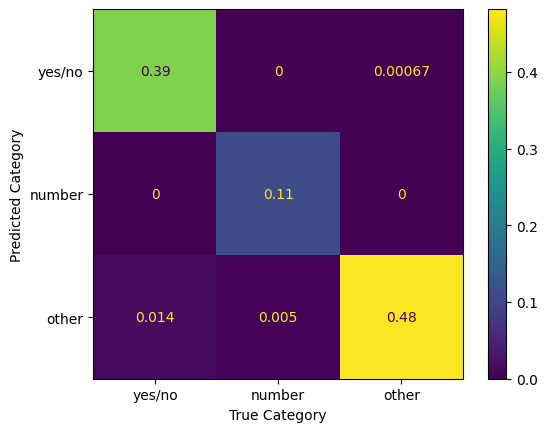

In [34]:
print("F1: ", metrics.f1_score(test_labels, pred_labels, average='weighted', labels=all_labels))
print("F1_macro: ", metrics.f1_score(test_labels, pred_labels, average='macro', labels=all_labels))
print("F1_micro: ", metrics.f1_score(test_labels, pred_labels, average='micro', labels=all_labels))
print("Precision: ", metrics.precision_score(test_labels, pred_labels, average='weighted', labels=all_labels))
print("Recall: ", metrics.recall_score(test_labels, pred_labels, average='weighted', labels=all_labels))
print("Confusion Matrix: \n", metrics.confusion_matrix(test_labels, pred_labels, labels=all_labels, normalize='all'))
print("Classification Report: \n", metrics.classification_report(test_labels, pred_labels, labels=all_labels))
metrics.ConfusionMatrixDisplay.from_predictions(test_labels, pred_labels, labels=all_labels, xticks_rotation='horizontal', normalize='all')

plt.xlabel("True Category")
plt.ylabel("Predicted Category")
plt.savefig('real', pad_inches=0.4, bbox_inches='tight')

In [12]:
import tqdm
from sklearn import metrics
def eval_yes_no(dataloader, model, epoch, mode="Val"):
    size = len(dataloader.dataset)
    print("Size",size)
    model.eval()
    correct_yes_no = 0
    yes_no_total = 0
    correct_number = 0
    number_total = 0
    correct_other = 0
    other_total = 0
    
    pbar = tqdm.tqdm(dataloader)
    index = 0
    test_labels = []
    pred_labels = []
    for img_b, question_input_ids_b, question_attention_mask_b, multiple_answers_input_ids_b, multiple_answers_attention_mask_b, correct_answers_input_ids_b, correct_answers_attention_mask_b in pbar:
        #for i in range(batch_size): 
        """"    
        question = element[i]["questions"]
        img = element[i]["imgs"]
        multiple_answers = element[i]["multiple_answers"]
        correct_answer = element[i]["correct_answers"]
        
        img = img_b[i].unsqueeze(0)
        question_input_ids = question_input_ids_b[i].unsqueeze(0)
        question_attention_mask = question_attention_mask_b[i].unsqueeze(0)
        multiple_answers_input_ids = multiple_answers_input_ids_b[i]
        multiple_answers_attention_mask = multiple_answers_attention_mask_b[i]
        correct_answers_input_ids = correct_answers_input_ids_b[i].unsqueeze(0)
        correct_answers_attention_mask = correct_answers_attention_mask_b[i].unsqueeze(0)
        """
        with torch.no_grad():
            idx = model(img_b, question_input_ids_b, question_attention_mask_b, answers_input_ids=multiple_answers_input_ids_b, answers_attention_mask = multiple_answers_attention_mask_b, train=False, inference='rank_compressed', k_test=18).to(device)
            # idx is shape [b]
            #print(idx.shape)
            # predicted answer is shape [b, len_ids]
            # multiple_answers_input_ids_b is shape [b,k, len_ids] -> get [b, len_ids] with the index respective to idx
            predicted_answer = multiple_answers_input_ids_b[torch.arange(multiple_answers_input_ids_b.size(0)), idx]
            #print("pred",predicted_answer.shape)
            # add for each in batch 30523
            
            predicted_answer[:,0] = 30523
            correct_answer = correct_answers_input_ids_b

            for i in range(batch_size):
                correct_answer_text = model.tokenizer.decode(correct_answer[i].detach().cpu().numpy(), skip_special_tokens=True)
                #print("correct",correct_answer_text)
                correct = int(np.array_equal(correct_answer[i].detach().cpu().numpy(), predicted_answer[i].detach().cpu().numpy()))
                

                predicted_answer_text = model.tokenizer.decode(predicted_answer[i].detach().cpu().numpy(), skip_special_tokens=True)
                if correct_answer_text == "yes" or correct_answer_text == "no":
                    if predicted_answer_text == "yes":
                        pred_labels.append("yes")
                    elif predicted_answer_text == "no":
                        pred_labels.append("no")
                    else:
                        pred_labels.append("other")
                    if correct_answer_text == "yes":
                        test_labels.append("yes")
                    elif correct_answer_text == "no":
                        test_labels.append("no")
            index += 1
    all_labels = ['yes','no', 'other']


    return test_labels, pred_labels, all_labels

    print("Total", yes_no_total + number_total + other_total)
    #Ploting results
    

In [13]:
test_labels, pred_labels, all_labels = eval_yes_no(test_dataloader, model, 0, mode="Test")

Size 3000


100%|██████████| 1500/1500 [05:24<00:00,  4.62it/s]


F1:  0.9307114849106609
F1_macro:  0.6190790833272293
F1_micro:  0.9297945205479452
Precision:  0.9318259151835654
Recall:  0.9297945205479452
Confusion Matrix: 
 [[0.54794521 0.03938356 0.00085616]
 [0.02910959 0.38184932 0.00085616]
 [0.         0.         0.        ]]
Classification Report: 
               precision    recall  f1-score   support

         yes       0.95      0.93      0.94       687
          no       0.91      0.93      0.92       481
       other       0.00      0.00      0.00         0

    accuracy                           0.93      1168
   macro avg       0.62      0.62      0.62      1168
weighted avg       0.93      0.93      0.93      1168



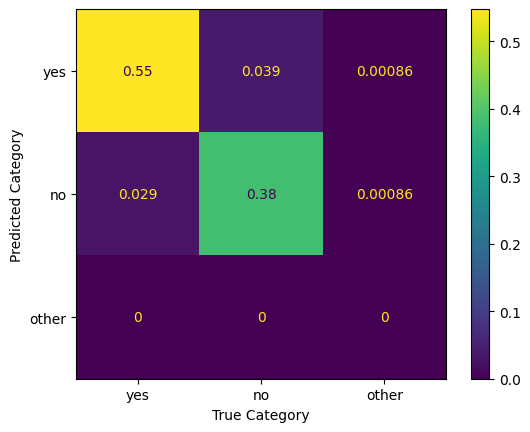

In [32]:
print("F1: ", metrics.f1_score(test_labels, pred_labels, average='weighted', labels=all_labels))
print("F1_macro: ", metrics.f1_score(test_labels, pred_labels, average='macro', labels=all_labels))
print("F1_micro: ", metrics.f1_score(test_labels, pred_labels, average='micro', labels=all_labels))
print("Precision: ", metrics.precision_score(test_labels, pred_labels, average='weighted', labels=all_labels))
print("Recall: ", metrics.recall_score(test_labels, pred_labels, average='weighted', labels=all_labels))
print("Confusion Matrix: \n", metrics.confusion_matrix(test_labels, pred_labels, labels=all_labels, normalize='all'))
print("Classification Report: \n", metrics.classification_report(test_labels, pred_labels, labels=all_labels))
# want matrix [yes, no] on y axis and [yes, no, other] on x axis
# remove also correspodning values

metrics.ConfusionMatrixDisplay.from_predictions(test_labels, pred_labels, labels=all_labels, xticks_rotation='horizontal', normalize='all')

plt.xlabel("True Category")
plt.ylabel("Predicted Category")
plt.savefig('real_yes_no', pad_inches=0.4, bbox_inches='tight')

In [9]:
print(f"Test Accuracy yes/no: {acc_yes_no}")
print(f"Test Accuracy number: {acc_number}")
print(f"Test Accuracy other: {acc_other}")
print(f"Test Accuracy all: {acc_all}")

Test Accuracy yes/no: 69.296875
Test Accuracy number: 52.9126213592233
Test Accuracy other: 61.69724770642202
Test Accuracy all: 63.733333333333334


In [9]:
import tqdm
#Evaluating raw model
def eval_rank(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    correct = 0
    pbar = tqdm.tqdm(dataloader)
    with torch.no_grad():
        for index, element in enumerate(pbar):
            for i in range(batch_size):     
                question = element[i]["questions"]
                img = element[i]["imgs"]
                multiple_answers = element[i]["multiple_answers"]
                correct_answer = element[i]["correct_answers"]
                        
                with torch.no_grad():
                    idx = model(img, question, answer = multiple_answers, train=False, inference='rank_compressed', k_test=18).item()
                    predicted_answer = multiple_answers["input_ids"][idx]
                    predicted_answer[0] = 30523
                    correct_answer = correct_answer["input_ids"][0]
                    #predicted_answer_decoded = model.tokenizer.decode(predicted_answer, skip_special_tokens=True)
                    #correct_answer_decoded = model.tokenizer.decode(correct_answer, skip_special_tokens=True)
                    #print(f"Predicted: {predicted_answer_decoded}, Correct: {correct_answer_decoded}")
                    #for answer in multiple_answers["input_ids"]:
                    #    answer[0] = 30523
                    #    print(model.tokenizer.decode(answer, skip_special_tokens=True))
                    comp = int(np.array_equal(correct_answer.detach().cpu().numpy(), predicted_answer.detach().cpu().numpy()))
                    #print(comp)
                    correct += comp
        
    print("Correct: ", correct)
    print("Size: ", size)
    correct /= size
    return 100*correct
#eval(val_dataloader, model) #63.5% with 4k images (using rank and model_base_vqa_capfilt_large)
#63.875% with 4k images(0.2) (using rank and model_base_vqa_capfilt_large)

In [10]:
acc = eval_rank(test_dataloader, model)
print(f"Test Accuracy: {acc}")

100%|██████████| 6000/6000 [22:19<00:00,  4.48it/s]

Correct:  10220
Size:  12000
Test Accuracy: 85.16666666666667
